In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.utils import to_categorical
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from time import time
import logging#程序进展信息
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split#分割数据集
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

C:\Users\huiqi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
ck_data = h5py.File('./CK_data.h5', 'r', driver='core')
X_data = np.expand_dims(np.asarray(ck_data['data_pixel']), axis=-1)
X_data = X_data.reshape((981,48*48))
y_data = np.asarray(ck_data['data_label'])
y_data = to_categorical(y_data)
n_classes = y_data.shape[1] #列维数

In [3]:
print(ck_data)

<HDF5 file "CK_data.h5" (mode r)>


In [4]:
print(X_data)

[[ 24  10  13 ... 150 153 156]
 [ 17  10  16 ... 151 153 156]
 [ 27  13  10 ... 148 152 156]
 ...
 [196 142 167 ...  59  56  42]
 [196 143 168 ...  59  56  41]
 [198 125 179 ...  59  54  40]]


In [5]:
print(y_data)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [6]:
print(n_classes)

7


In [7]:
print(y_data.shape[0])

981


In [8]:
X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size=0.2)

In [9]:
print('Training: ',X_train.shape)

Training:  (784, 2304)


In [10]:
print('Validation: ',X_validation.shape)

Validation:  (197, 2304)


In [11]:
#使用主成分分析(PCA)降维
n_components = 10
#因为特征值维度比较高，所以需要降低维度，提取特征
pca =PCA(svd_solver='randomized',n_components=n_components,whiten=True).fit(X_train)
#得到训练集投影系数
X_train_pca = pca.transform(X_train)
#得到测试集投影系数
X_val_pca = pca.transform(X_validation) 

In [12]:
print(X_train_pca)

[[ 1.32769486  2.52051464  0.42113607 ...  0.41501506  1.03336454
  -1.34981253]
 [-1.50484225  1.37503229  0.57363848 ... -0.02658795 -0.01302682
  -0.4186663 ]
 [-0.83420981  0.15712091 -1.60240034 ...  0.51553633  0.18900149
  -0.24329886]
 ...
 [ 0.07484525  0.65804402 -0.39022781 ...  1.04774147  1.49154894
  -0.49038821]
 [-1.11548546 -0.74433681  1.45500605 ... -0.6180308  -0.77045129
  -1.57420821]
 [ 1.46485189 -0.90790322  0.18559117 ...  0.32377644  1.80896789
  -0.4886464 ]]


In [13]:
print(X_val_pca)

[[-0.04828533  0.52339603 -0.69507794 ...  0.60949706 -0.51886347
  -0.68884163]
 [-0.94672954  0.30122914 -1.04467779 ... -1.40184702 -0.49374204
  -0.20325135]
 [-0.66843241  0.55528867  0.63875851 ...  0.21904689 -0.94263777
   0.16129622]
 ...
 [-0.02060361  0.69811282  0.6369828  ... -0.07940815 -0.961717
   0.11971262]
 [-0.87259561 -0.08399892 -0.99156632 ... -0.44448481 -0.29359552
  -0.63547652]
 [ 0.26411482  0.66817852  0.14539679 ...  0.28403177  0.58821924
  -1.73825726]]


In [14]:
print(X_train)

[[200 200 200 ... 191 191 191]
 [193 106  36 ... 120 120 123]
 [100 103  76 ...  76  77  76]
 ...
 [ 87  88  88 ...  91  91  90]
 [190 195 171 ...  63  65  62]
 [ 24  25  27 ...  34  34  33]]


In [15]:
eigenfaces = pca.components_.reshape((n_components, 48, 48))

In [19]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [20]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]

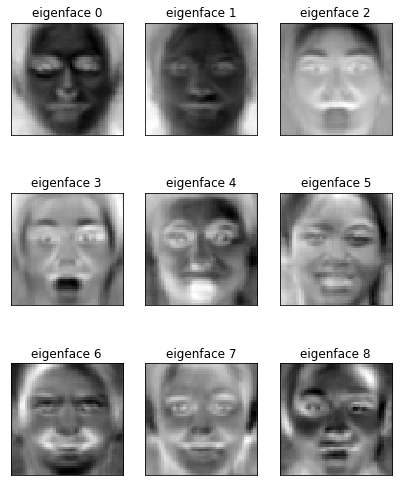

In [21]:
plot_gallery(eigenfaces, eigenface_titles, 48, 48)

In [22]:
plt.show()

In [23]:
y_train_ = np.argmax(y_train, axis=-1)

In [24]:
y_train_.shape

(784,)

In [25]:
#训练SVM分类器
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
#class_weight='balanced'表示调整各类别权重，权重与该类中样本数成反比，
#防止模型过于拟合某个样本数量过大的类
clf = clf.fit(X_train_pca, y_train_)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 3.952s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [26]:
#验证
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_val_pca)
print("done in %0.3fs" % (time() - t0))
y_val = np.argmax(y_validation, axis=-1)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.003s
             precision    recall  f1-score   support

          0       0.91      0.91      0.91        33
          1       0.85      0.92      0.88        37
          2       1.00      0.80      0.89        15
          3       1.00      1.00      1.00        44
          4       1.00      1.00      1.00        12
          5       1.00      1.00      1.00        42
          6       1.00      1.00      1.00        14

avg / total       0.96      0.95      0.95       197

[[30  3  0  0  0  0  0]
 [ 3 34  0  0  0  0  0]
 [ 0  3 12  0  0  0  0]
 [ 0  0  0 44  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 42  0]
 [ 0  0  0  0  0  0 14]]
